In [29]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
from scipy.stats.distributions import chi2
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
#end = '2023-01-01'
raw_data = yf.download(tickers = '^NSEI ^SPX', start = '2010-01-01', end = '2023-01-01',interval = '1d', group_by = 'ticker',auto_adjust = True, threads = True)
raw_data.head()
df = raw_data.copy()
df['nifty'] = raw_data['^NSEI'].Close[:]
df['spx'] = raw_data['^SPX'].Close[:]
#df = df.iloc[1:]
del df['^NSEI']
del df['^SPX']
df = df.asfreq('b')
df['nifty'].fillna(method = 'ffill',inplace = True)
df['spx'].fillna(method = 'ffill',inplace = True)


[*********************100%***********************]  2 of 2 completed


In [31]:
df['Returns_n'] = df.nifty.pct_change(1)*100
df['Returns_s'] = df.spx.pct_change(1)*100
print(len(df['Returns_n']))
print(len(df['Returns_s']))
#df['Sq Returns'] = df['Returns'].mul(df['Returns'])

3390
3390


# SPLITTING THE DATA

In [32]:
size = int(len(df)*0.8)
df, df_test = df.iloc[:size], df.iloc[size:]
df.tail()

,nifty,spx,Returns_n,Returns_s
,,,,
Date,,,,
2020-05-20,9066.549805,2971.610107,2.111140,1.665110
2020-05-21,9106.250000,2948.510010,0.437875,-0.777360
2020-05-22,9039.250000,2955.449951,-0.735758,0.235371
2020-05-25,9039.250000,2955.449951,0.000000,0.000000
2020-05-26,9029.049805,2991.770020,-0.112843,1.228918


# Fitting simple AR

In [33]:
model_ar = ARIMA(df['nifty'],order = (1,0,0)).fit()

In [34]:
df['nifty'].tail()

Date
2020-05-20    9066.549805
2020-05-21    9106.250000
2020-05-22    9039.250000
2020-05-25    9039.250000
2020-05-26    9029.049805
Freq: B, Name: nifty, dtype: float64

In [35]:
#start and end must be business days otherwise the code will fail
start = '2020-06-29'
end = '2020-07-24'
ar_pred = model_ar.predict(start= start,end = end)
df.tail()

,nifty,spx,Returns_n,Returns_s
,,,,
Date,,,,
2020-05-20,9066.549805,2971.610107,2.111140,1.665110
2020-05-21,9106.250000,2948.510010,0.437875,-0.777360
2020-05-22,9039.250000,2955.449951,-0.735758,0.235371
2020-05-25,9039.250000,2955.449951,0.000000,0.000000
2020-05-26,9029.049805,2991.770020,-0.112843,1.228918


Text(0.5, 1.0, 'Predictions')

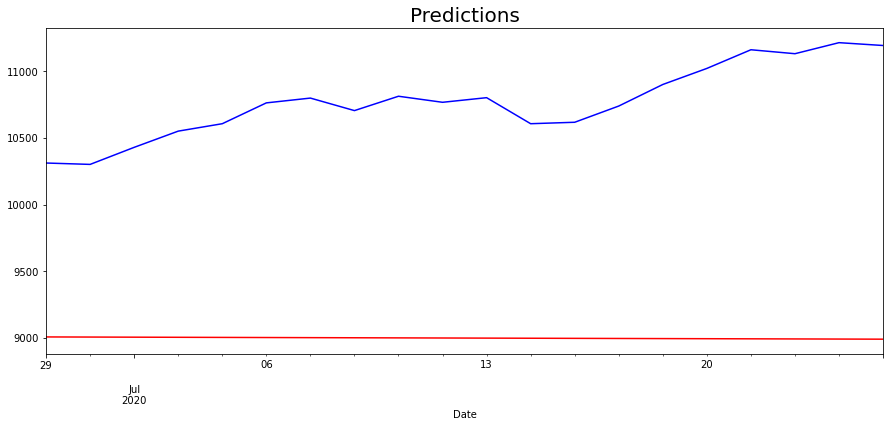

In [36]:
ar_pred[start:end].plot(figsize = (15,6), color = 'red')
df_test['nifty'][start:end].plot(color = 'blue')
plt.title('Predictions',size = 20)

# Using Returns in AR

Text(0.5, 1.0, 'Predictions of Returns')

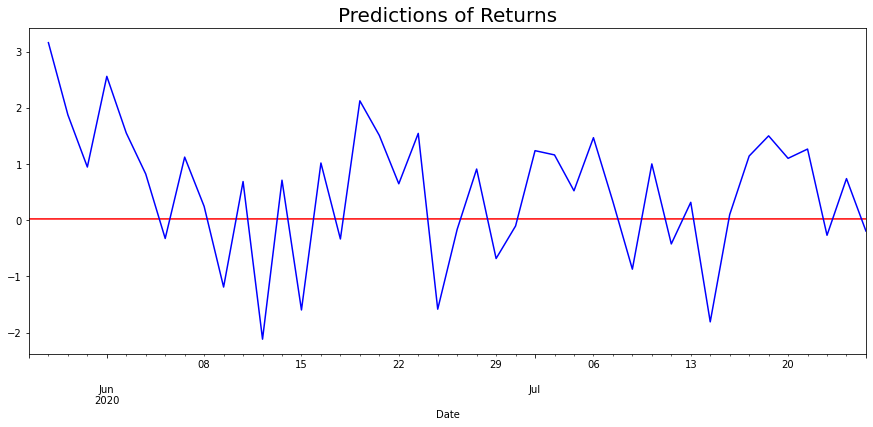

In [37]:
start = '2020-05-26'
model_ar_ret = ARIMA(df['Returns_n'][1:],order = (1,0,0)).fit()
ar_pred_ret = model_ar_ret.predict(start= start,end = end)
ar_pred_ret[start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

# MA

Text(0.5, 1.0, 'Predictions of Returns')

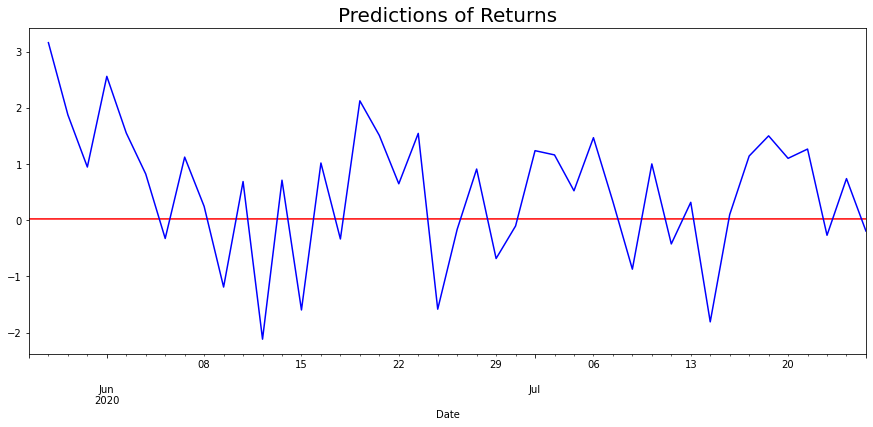

In [38]:
start = '2020-05-26'
model_ma_ret = ARIMA(df['Returns_n'][1:],order = (0,0,1)).fit()
ma_pred_ret = model_ma_ret.predict(start= start,end = end)
ma_pred_ret[start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

# ARMAX

Text(0.5, 1.0, 'Predictions of Returns')

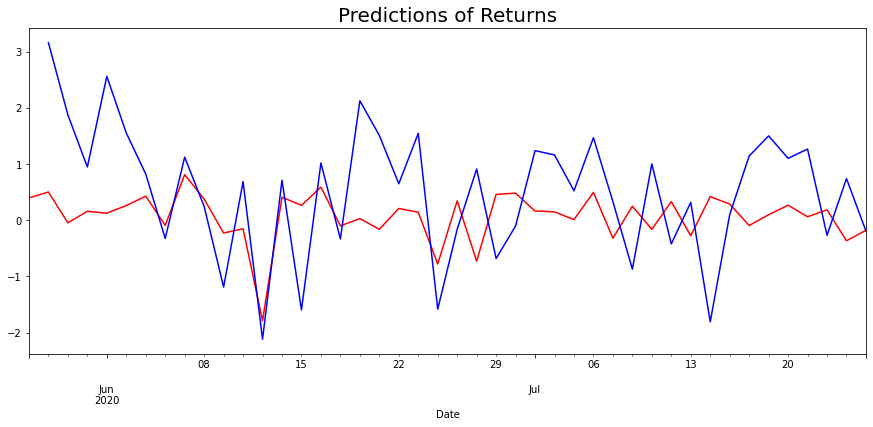

In [39]:
model_armax111 = ARIMA(df['Returns_n'][1:],order = (1,0,1),exog = df['Returns_s'][1:]).fit()
model_armax111_pred = model_armax111.predict(start = start, end = end, exog = df_test['Returns_s'][start:end])
model_armax111_pred[start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

# SARIMAX

Text(0.5, 1.0, 'Predictions of Returns')

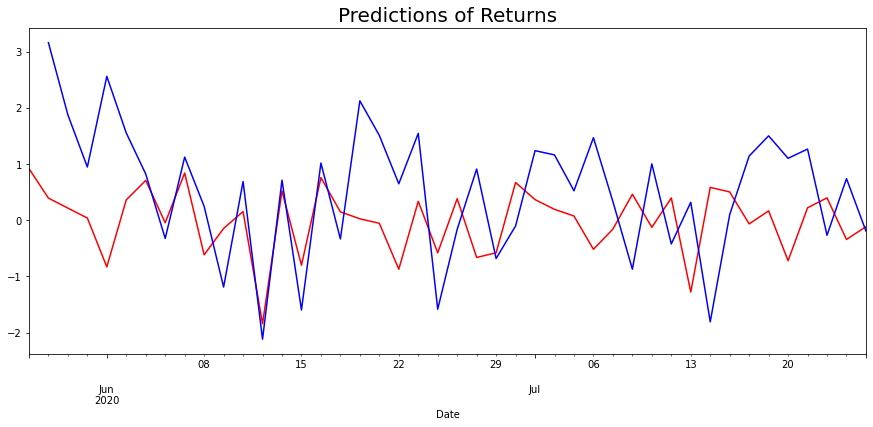

In [40]:
#start = '2020-06-29'
#end = '2021-06-28'
model_sarimax = SARIMAX(df['Returns_n'][1000:],order = (3,1,4),exog = df['Returns_s'][1000:],seasonal_order = (3,0,2,5)).fit()
model_sarimax_pred = model_sarimax.predict(start = start, end = end, exog = df_test['Returns_s'][start:end])
model_sarimax_pred[start:end].plot(figsize = (15,6), color = 'red')
df_test['Returns_n'][start:end].plot(color = 'blue')
plt.title('Predictions of Returns',size = 20)

In [41]:
df['sarimax'] = model_sarimax.resid
print('Mean of residuals is:',df.sarimax.mean())
print('Volatility of residuals is:',np.sqrt(df.sarimax.var()))

Mean of residuals is: -0.006581800140962196
Volatility of residuals is: 0.9862705795389526


# AUTO ARIMA

In [42]:
model_auto = auto_arima(df['Returns_n'][1000:],exogeneous =df['Returns_s'][1000:], m =5, max_order = None, max_p = 7,max_q = 7, max_d = 2, max_P = 4,max_Q = 4, max_D = 2, maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'aic', out_of_sample_size = int(len(df)*0.2))
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start:end])), index = df_test[start:end].index)


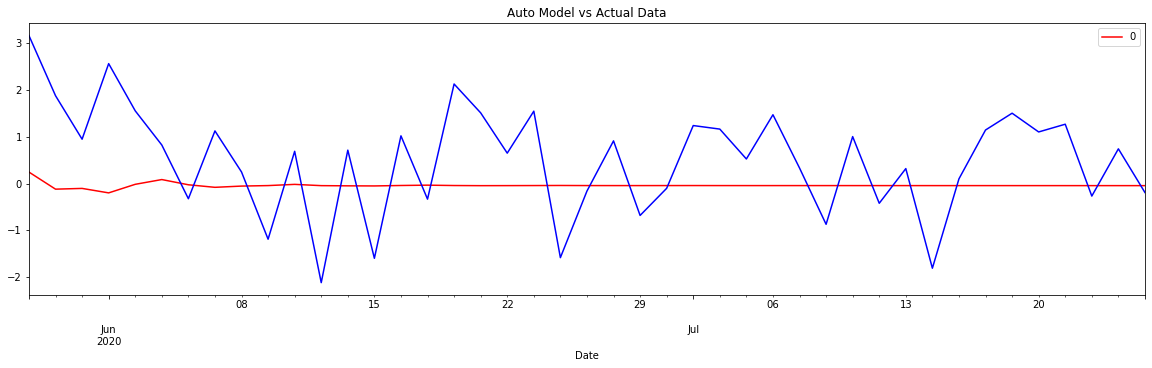

In [43]:
df_auto_pred.plot(figsize = (20,5), color = 'red')
df_test.Returns_n[start:end].plot(color = 'blue')
plt.title("Auto Model vs Actual Data")
plt.show()

# Comparing all  models

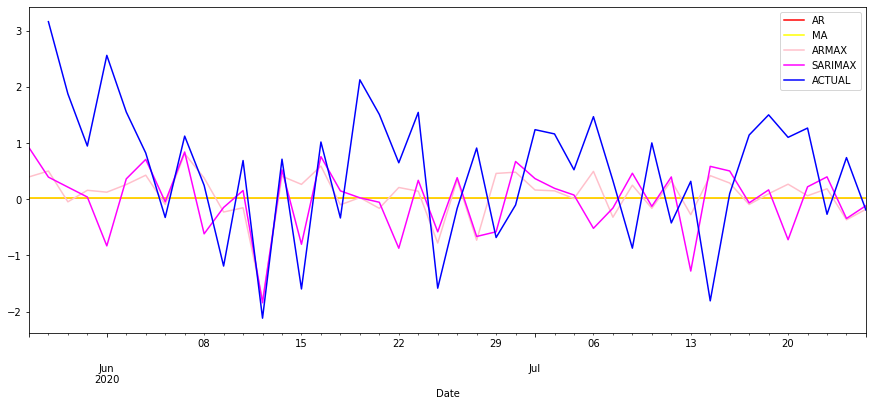

In [49]:
ar_pred_ret[start:end].plot(figsize = (15,6), color = 'red')
ma_pred_ret[start:end].plot(figsize = (15,6), color = 'yellow')
model_armax111_pred[start:end].plot(figsize = (15,6), color = 'pink')
model_sarimax_pred[start:end].plot(figsize = (15,6), color = 'magenta')
df_test['Returns_n'][start:end].plot(figsize = (15,6),color = 'blue')
plt.legend(['AR','MA','ARMAX','SARIMAX','ACTUAL'])
plt.show()